In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import pandas as pd
import importlib
from numpy import random
importlib.import_module('mpl_toolkits.mplot3d').__path__
%matplotlib inline
np.random.seed(0)


Bad key "ckend" on line 1 in
/Users/songzeli/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def FFT_surrogates(ts):
    """
    Return Fourier surrogates.
    
    Generate surrogates by Fourier transforming the time series, randomizing the phases and
    then applying an inverse Fourier transform. Correlated noise surrogates
    share their power spectrum and autocorrelation function with the
    original_data time series.

    Input type: timeseries array 
    Return: The surrogate time series.
    """
    #  Calculate FFT of original_data time series
    ts_fourier  = np.fft.rfft(ts)
    random_phases = np.exp(np.random.uniform(0,np.pi,len(ts)//2+1)*1.0j)
    ts_fourier_new = ts_fourier*random_phases
    new_ts = np.fft.irfft(ts_fourier_new)
    
    return new_ts

In [3]:
def AAFT_surrogates(ts):
    """
    Return surrogates using the amplitude adjusted Fourier transform
    method.

    Input: Orinal time series
    Return: The surrogate time series.
    """
    index = [i for i in range(len(ts))]
    con_ts = np.array([index,ts])
    
    #  Create sorted Gaussian reference series
    gaussian = random.randn(con_ts.shape[0], con_ts.shape[1])
    gaussian.sort(axis=1)

    #  Rescale data to Gaussian distribution
    ranks = con_ts.argsort(axis=1).argsort(axis=1)
    rescaled_data = np.zeros(con_ts.shape)

    for i in range(con_ts.shape[0]):
        rescaled_data[i, :] = gaussian[i, ranks[i, :]]

    #  Phase randomize rescaled data
    phase_randomized_data = FFT_surrogates(ts)
    phase_randomized_data = np.array([index,phase_randomized_data])

    #  Rescale back to amplitude distribution of original data
    sorted_original = con_ts.copy()
    sorted_original.sort(axis=1)

    ranks = phase_randomized_data.argsort().argsort()

    for i in range(con_ts.shape[0]):
        rescaled_data[i, :] = sorted_original[i, ranks[i,:]]

    return rescaled_data[1]


In [4]:
def refined_AAFT_surrogates(ts,n_iterations,output="true_amplitudes"):
    """
    Return surrogates using the iteratively refined amplitude adjusted
    Fourier transform method, which iteratively
    refined to produce a closer match of both amplitude distribution and
    power spectrum of surrogate and original data.

    Input: Orinal time series
    Return: The surrogate time series.
    """
    #  Get size of dimensions
    index = [i for i in range(len(ts))]
    original_data = np.array([index,ts])
    n_time = original_data.shape[1]

    #  Get Fourier transform of original data with caching
    fourier_transform = np.fft.rfft(original_data, axis=1)
    original_data_fft = fourier_transform


    #  Get Fourier amplitudes
    original_fourier_amps = np.abs(fourier_transform)

    #  Get sorted copy of original data
    sorted_original = original_data.copy()
    sorted_original.sort(axis=1)

    #  Get starting point / initial conditions for R surrogates
    R = AAFT_surrogates(original_data[1])
    index = [i for i in range(len(R))]
    R = np.array([index,R])

    #  Start iteration
    for i in range(n_iterations):
        #  Get Fourier phases of R surrogate
        r_fft = np.fft.rfft(R, axis=1)
        r_phases = r_fft / np.abs(r_fft)

        #  Transform back, replacing the actual amplitudes by the desired
        #  ones, but keeping the phases 
        s = np.fft.irfft(original_fourier_amps * r_phases, n=n_time,
                         axis=1)

        #  Rescale to desired amplitude distribution
        ranks = s.argsort(axis=1).argsort(axis=1)

        for j in range(original_data.shape[0]):
            R[j, :] = sorted_original[j, ranks[j, :]]

    if output == "true_amplitudes":
        return R[1]
    elif output == "true_spectrum":
        return s[1]


In [5]:
def plot_autocorrelation(new_ts,sur = False):
    pd.tools.plotting.autocorrelation_plot(new_ts)
    plt.ylim([-1,1])
    if sur:
        plt.title('Autocorrelation function of surrogate time series')
    else:
        plt.title('Autocorrelation function of original time series')
    plt.show()
    
    
def plot_ts_comparision(ts,new_ts,ran = 1000):
    plt.plot(ts[0:ran],label='original time series')
    plt.plot(new_ts[0:ran],label='surrogate time series')
    plt.legend()
    plt.title('Comparison between original time series and surrogate time series')
    plt.show()

Integration successful.


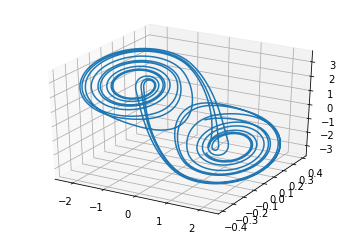

In [6]:
#define universal variables
c0 = 15.6
c1 = 1.0
c2 = 28.0
m0 = -1.143
m1 = -0.714

#just a little extra, quite unimportant
def f(x):
    f = m1*x+(m0-m1)/2.0*(abs(x+1.0)-abs(x-1.0))
    return f

#the actual function calculating
def dH_dt(H, t=0):
    return np.array([c0*(H[1]-H[0]-f(H[0])),
                  c1*(H[0]-H[1]+H[2]),
                  -c2*H[1]])

#computational time steps
t = np.linspace(0, 30, 10000)
#x, y, and z initial conditions
H0 = [0.7, 0.0, 0.0]

H, infodict = integrate.odeint(dH_dt, H0, t, full_output=True)

print (infodict['message'])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(H[:,0], H[:,1], H[:,2])
plt.show()


x = H[:,0]
y = H[:,1]
z = H[:,2]

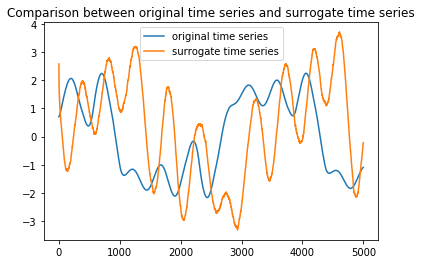

/Users/songzeli/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


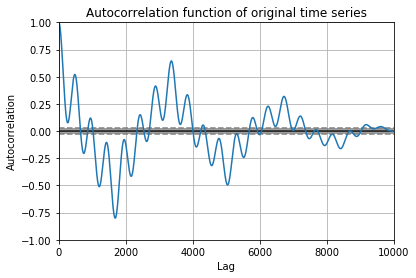

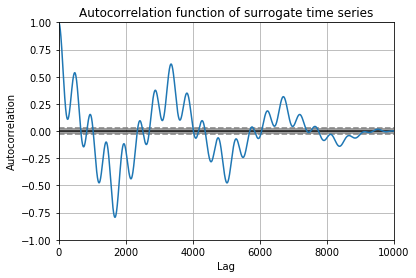

In [7]:
new_ts = FFT_surrogates(z)
plot_ts_comparision(x,new_ts,5000)
plot_autocorrelation(z)
plot_autocorrelation(new_ts,sur=True)

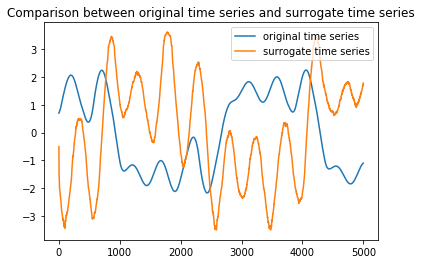

/Users/songzeli/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


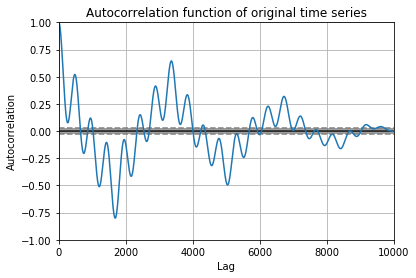

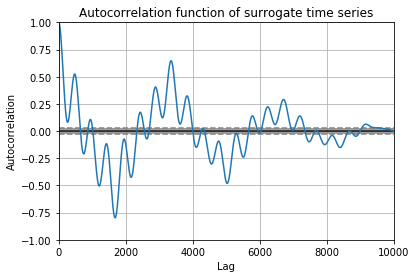

In [8]:
new_ts = AAFT_surrogates(z)
plot_ts_comparision(x,new_ts,5000)
plot_autocorrelation(z)
plot_autocorrelation(new_ts,sur=True)

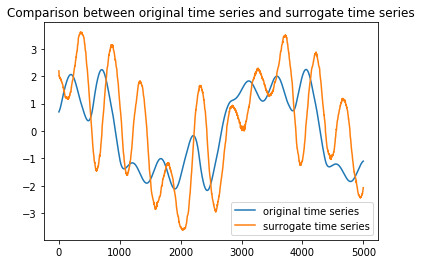

/Users/songzeli/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


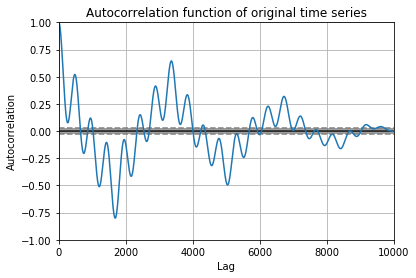

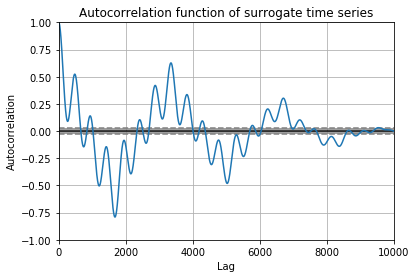

In [9]:
new_ts = refined_AAFT_surrogates(z,5000)
plot_ts_comparision(x,new_ts,5000)
plot_autocorrelation(z)
plot_autocorrelation(new_ts,sur=True)

In [10]:
#Generate_Spike_Response Model

import numpy as np
import functools

class SRM:
    """ SRM_0 (Spike Response Model) """
    def __init__(self, neurons, threshold, t_current, t_membrane, eta_reset, simulation_window_size=100, verbose=False):
        """
        Neurons can have different threshold, t_current, t_membrane and eta_resets: Set those variables to 1D np.arrays of all the same size.

        :param neurons: Number of neurons
        :param threshold: Spiking threshold
        :param t_current: Current-time-constant (:math:`t_s`)
        :type t_current: Float or Numpy Float Array
        :param t_membrane: Membrane-time-constant (t_m)
        :param eta_reset: Reset constant
        :param simulation_window_size: Only look at the n last spikes
        :param verbose: Print verbose output to the console
        :return: ``None``
        """

        # Check user input
        try: neurons = int(neurons)
        except: raise ValueError("Variable neurons should be int or convertible to int")

        # threshold, t_current, t_membrane, and eta_reset are all vector
        threshold = np.array(threshold)
        t_current = np.array(t_current)
        t_membrane = np.array(t_membrane)
        eta_reset = np.array(eta_reset)

        if not(threshold.shape == t_current.shape == t_membrane.shape == eta_reset.shape):
            raise ValueError("Vector of threshhold, t_current, t_membrane, and eta_reset must be same size")

        try: simulation_window_size = int(simulation_window_size)
        except: raise ValueError("Variable simulation_window_size should be int or convertible to int")

        self.neurons = neurons
        self.threshold = threshold
        self.t_current = t_current
        self.t_membrane = t_membrane
        self.eta_reset = eta_reset
        self.simulation_window_size = simulation_window_size
        self.verbose = verbose
        self.cache = {}
        self.cache['last_t'] = -1
        self.cache['last_spike'] = np.ones(self.neurons, dtype=float) * -1000000
        self.cache['last_potential'] = np.zeros(self.neurons, dtype=float)

    def eta(self, s):
        r"""
        Evaluate the Eta function:

        .. math:: \eta (s) = - \eta_{reset} * \exp(\frac{- s}{\tau_m})
            :label: eta

        :param s: Time s
        :return: Function eta(s) at time s
        :return type: Float or Vector of Floats
        """

        return - self.eta_reset*np.exp(-s/self.t_membrane)

    @functools.lru_cache()
    def eps(self, s):
        r"""
        Evaluate the Epsilon function:

        .. math:: \epsilon (s) =  \frac{1}{1 - \frac{\tau_c}{\tau_m}} (\exp(\frac{-s}{\tau_m}) - \exp(\frac{-s}{\tau_c}))
            :label: epsilon

        Returns a single Float Value if the time constants (current, membrane) are the same for each neuron.
        Returns a Float Vector with eps(s) for each neuron, if the time constants are different for each neuron.

        :param s: Time s
        :return: Function eps(s) at time s
        :rtype: Float or Vector of Floats
        """
        return (1/(1-self.t_current/self.t_membrane))*(np.exp(-s/self.t_membrane) - np.exp(-s/self.t_current))

    @functools.lru_cache()
    def eps_matrix(self, k, size):
        """

        Returns the epsilon helpermatrix.

        :Example:

        >>> eps_matrix(3, 5)
        [[eps_0(3), eps_0(2), eps_0(1), eps_0(0), eps_0(0)],
         [eps_1(3), eps_1(2), eps_1(1), eps_1(0), eps_1(0)]]

        Where `eps_0(3)` means the epsilon function of neuron 0 at time 3.

        :param k: Leftmost epsilon time
        :param size: Width of the return matrix
        :return: Epsilon helper matrix
        :return type: Numpy Float Array, dimensions: (neurons x size)
        """

        matrix = np.zeros((self.neurons, size), dtype=float)

        for i in range(k):
            matrix[:, i] = self.eps(k-i)

        return matrix

    def check_spikes(self, spiketrain, weights, t, additional_term=None):
        """
        Simulate one time step at time t. Changes the spiketrain in place at time t!
        Return the total membrane potential of all neurons.

        :param spiketrain: Spiketrain (Time indexing begins with 0)
        :param weights: Weights
        :param t: Evaluation time
        :param additional_term: Additional potential that gets added before we check for spikes (For example for extern voltage)
        :return: total membrane potential of all neurons at time step t (vector), spikes at time t
        """

        # Check correct user input

        if type(spiketrain) != np.ndarray:
            raise ValueError("Spiketrain should be a numpy array")

        if type(weights) != np.ndarray:
            raise ValueError("Weights should be a numpy matrix")

        if additional_term != None and type(additional_term) != np.ndarray:
            raise ValueError("Additional_term should be a numpy array")

        try: t = int(t)
        except: raise ValueError("Variable t should be int or convertible to int")

        if t < 0:
            raise ValueError("Time to be simulated is too small")

        if t >= spiketrain.shape[1]:
            raise ValueError("Spiketrain too short (0ms -- %dms) for simulating time %d" % (spiketrain.shape[1]-1, t))

        if weights.shape[0] != self.neurons or self.neurons != weights.shape[1]:
            raise ValueError("Weigths should be a quadratic matrix, with one row and one column for each neuron")

        if spiketrain.shape[0] != self.neurons:
            raise ValueError("Spikes should be a matrix, with one row for each neuron")

        if additional_term != None and additional_term.shape[0] != self.neurons:
            raise ValueError("Additional_term should be a vector with one element for each neuron")

        if additional_term != None and len(additional_term) == 2 and additional_term.shape[1] != 1:
            raise ValueError("Additional_term should be a vector with one element for each neuron")

        # Work on a windowed view
        spiketrain_window = spiketrain[:, max(0, t+1-self.simulation_window_size):t+1]

        # Retrieve necessary simulation data from cache if possible
        if self.cache['last_t'] == -1 or self.cache['last_t'] == t - 1:
            last_spike = self.cache['last_spike']
            last_potential = self.cache['last_potential']
        else:
            last_spike = t - np.argmax(spiketrain_window[:, ::-1], axis=1)
            # TODO find a way to calculate last_potential (recursive call to check_spikes is not a good option)
            last_potential = np.zeros(self.neurons)

        neurons, timesteps = spiketrain_window.shape

        epsilon_matrix = self.eps_matrix(min(self.simulation_window_size, t), timesteps)

        # Calculate current
        incoming_spikes = np.dot(weights.T, spiketrain_window)
        incoming_potential = np.sum(incoming_spikes * epsilon_matrix, axis=1)
        total_potential = self.eta(np.ones(neurons)*t - last_spike) + incoming_potential
        # Calculate current end

        # Add additional term (user-defined)
        if additional_term != None:
            total_potential += additional_term

        # Any new spikes? Only spike if potential hits the threshold from below.
        neurons_high_current = np.where((total_potential > self.threshold) & (last_potential < self.threshold))
        spiketrain[neurons_high_current, t] = True

        # Update cache (last_spike, last_potential and last_t)
        spiking_neurons = np.where(spiketrain[:, t])
        self.cache['last_spike'][spiking_neurons] = t
        self.cache['last_potential'] = total_potential
        self.cache['last_t'] = t

        if self.verbose:
            print("SRM Time step", t)
            print("Incoming current", incoming_potential)
            print("Total potential", total_potential)
            print("Last spike", last_spike)
            print("")

        return total_potential

class SRM_X(SRM):
    def __init__(self, neurons, threshold, t_current, t_membrane, eta_reset, ax_delay, simulation_window_size=100, verbose=False):
        """
        Like the SRM model, but additionally it supports axonal delays.

        :param neurons: Number of neurons
        :param threshold: Spiking threshold
        :param t_current: Current-time-constant (:math:`t_s`)
        :type t_current: Float or Numpy Float Array
        :param t_membrane: Membrane-time-constant (t_m)
        :param eta_reset: Reset constant
        :param ax_delay: Axonal delays
        :param simulation_window_size: Only look at the n last spikes
        :param verbose:
        :return: ``None``
        """

        # Check user input
        # TODO

        SRM.__init__(self, neurons, threshold, t_current, t_membrane, eta_reset, simulation_window_size=simulation_window_size,
                     verbose=verbose)

        self.ax_delay = ax_delay

    def eps(self, s):
        r"""
        Evaluate the Epsilon function with an axonal delay :math:`\tau_d`.

        .. math:: \epsilon (s) =  \frac{1}{1 - \frac{\tau_c}{\tau_m}} (\exp(\frac{-(s-\tau_d)}{\tau_m}) - \exp(\frac{-(s - \tau_d)}{\tau_c}))
            :label: epsilon_axdelay

        Returns a single Float Value if the time constants (current, membrane) are the same for each neuron.
        Returns a Float Vector with eps(s) for each neuron, if the time constants are different for each neuron.

        :param s: Time s
        :return: Function eps(s) at time s
        :rtype: Float or Vector of Floats
        """
        eps = (1/(1-self.t_current/self.t_membrane))*(np.exp(-(s - self.ax_delay)/self.t_membrane)
                                                       - np.exp(- (s - self.ax_delay)/self.t_current))

        eps[np.where(eps<0)] = 0
        return eps



    srm_model = SRM(neurons=3, threshold=1, t_current=0.3, t_membrane=20, eta_reset=5, verbose=True)

    models = [srm_model]

    for model in models:
        print("-"*10)
        if isinstance(model, SRM):
            print('Demonstration of the SRM Model')

        s = np.array([[0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
                      [1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

        w = np.array([[0, 0, 1], [0, 0, 1], [0, 0, 0]])
        neurons, timesteps = s.shape

        for t in range(timesteps):
            total_current = model.check_spikes(s, w, t)
            print("Spiketrain:")
            print(s)

----------
Demonstration of the SRM Model
SRM Time step 0
Incoming current [0. 0. 0.]
Total potential [0. 0. 0.]
Last spike [-1000000.        0. -1000000.]

Spiketrain:
[[0 0 1 0 0 0 1 1 0 0]
 [1 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
SRM Time step 1
Incoming current [0.        0.        0.9294979]
Total potential [ 0.         -4.75614712  0.9294979 ]
Last spike [-1000000.        0. -1000000.]

Spiketrain:
[[0 0 1 0 0 0 1 1 0 0]
 [1 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
SRM Time step 2
Incoming current [0.         0.         0.91732465]
Total potential [ 0.         -4.52418709  0.91732465]
Last spike [ 2.e+00  0.e+00 -1.e+06]

Spiketrain:
[[0 0 1 0 0 0 1 1 0 0]
 [1 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
SRM Time step 3
Incoming current [0.         0.         1.80326701]
Total potential [-4.75614712 -4.30353988  1.80326701]
Last spike [2. 0. 3.]

Spiketrain:
[[0 0 1 0 0 0 1 1 0 0]
 [1 0 0 0 0 0 1 1 0 0]
 [0 0 0 1 0 0 0 0 0 0]]
SRM Time step 4
Incoming current [0.         0.

[[[0.        ]
  [0.        ]]

 [[0.        ]
  [0.10368461]]

 [[0.10368461]
  [0.20722381]]

 ...

 [[0.19393701]
  [0.50013827]]

 [[0.20260692]
  [0.50635146]]

 [[0.200874  ]
  [0.60513384]]]


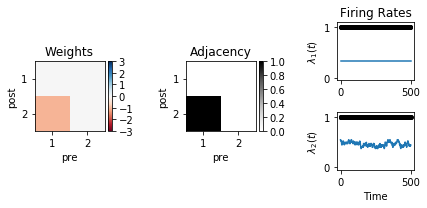

In [11]:
from pyglm.utils.basis import cosine_basis
from pyglm.plotting import plot_glm
from pyglm.models import SparseBernoulliGLM
# Create a simple, sparse network of four neurons
T = 10000   # Number of time bins to generate
N = 2       # Number of neurons
B = 1       # Number of "basis functions"
L = 10     # Autoregressive window of influence

# Create a cosine basis to model smooth influence of
# spikes on one neuron on the later spikes of others.
basis = cosine_basis(B=B, L=L) / L

# Generate some data from a model with self inhibition
true_model = SparseBernoulliGLM(N, basis=basis)

# Generate T time bins of events from the the model
# Y is the generated spike train.
# X is the filtered spike train for inference.
X, Y = true_model.generate(T=T, keep=True)

# Plot the model parameters and data
true_model.plot()


# # Create the test model and add the spike train
# test_model = SparseBernoulliGLM(N, basis=basis)
# test_model.add_data(Y)

# # Initialize the plot
# _, _, handles = test_model.plot()

# # Run a Gibbs sampler
# N_samples = 100
# lps = []
# for itr in xrange(N_samples):
#     test_model.resample_model()
#     lps.append(test_model.log_likelihood())
#     test_model.plot(handles=handles)

print(X)

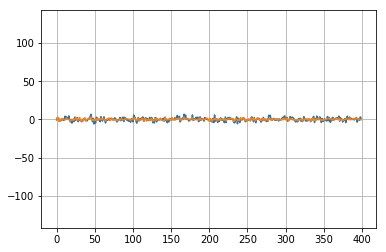

In [12]:
# """Example of generating correlated normally distributed random samples."""
# To generate correlated normally distributed random samples, one can first generate uncorrelated samples, and then multiply them by a matrix C such that CCT=R
# , where R is the desired covariance matrix. C can be created, for example, by using the Cholesky decomposition of R, or from the eigenvalues and eigenvectors of R.
import numpy as np
from scipy.linalg import eigh, cholesky
from scipy.stats import norm

# Choice of cholesky or eigenvector method.
method = 'cholesky'
#method = 'eigenvectors'

num_samples = 400

# The desired covariance matrix.
r = np.array([
        [  3.40, -2.75, -2.00],
        [ -2.75,  5.50,  1.50],
        [ -2.00,  1.50,  1.25]])
# Generate samples from three independent normally distributed random
# variables (with mean 0 and std. dev. 1).
x = norm.rvs(size=(3, num_samples))

# We need a matrix `c` for which `c*c^T = r`.  We can use, for example,
# the Cholesky decomposition, or the we can construct `c` from the
# eigenvectors and eigenvalues.

if method == 'cholesky':
    # Compute the Cholesky decomposition.
    c = cholesky(r, lower=True)
else:
    # Compute the eigenvalues and eigenvectors.
    evals, evecs = eigh(r)
    # Construct c, so c*c^T = r.
    c = np.dot(evecs, np.diag(np.sqrt(evals)))

# Convert the data to correlated random variables. 
y = np.dot(c, x)

# Plot various projections of the samples.

plt.plot(y[1])
plt.plot(y[2])
plt.ylim(-0.1,0.1)
plt.axis('equal')
plt.grid(True)
plt.show()


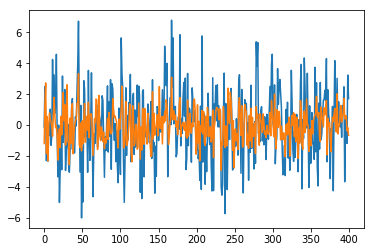

In [13]:
plt.plot(y[1])
plt.plot(y[2])
plt.show()

In [14]:
import numpy as np
data = np.random.normal(5, 10, size=(10,))

In [15]:
from bayespy.nodes import GaussianARD, Gamma
mu = GaussianARD(0, 1e-6)
# tu = GaussianARD(5, 10)
tau = Gamma(1e-6, 1e-6)
y = GaussianARD(mu, tau, plates=(10,))

/Users/songzeli/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [16]:
obv = y.observe(data)

In [17]:
from bayespy.inference import VB
Q = VB(mu, tau, y)
Q.update(repeat=20)

Iteration 1: loglike=-5.765059e+01 (0.003 seconds)
Iteration 2: loglike=-5.590006e+01 (0.006 seconds)
Iteration 3: loglike=-5.589770e+01 (0.002 seconds)
Iteration 4: loglike=-5.589768e+01 (0.002 seconds)
Converged at iteration 4.


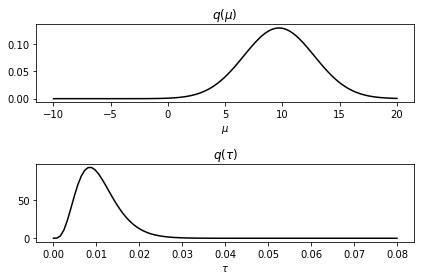

In [18]:
import bayespy.plot as bpplt
bpplt.pyplot.subplot(2, 1, 1)
bpplt.pdf(mu, np.linspace(-10, 20, num=100), color='k', name=r'\mu')
bpplt.pyplot.subplot(2, 1, 2)
bpplt.pdf(tau, np.linspace(1e-6, 0.08, num=100), color='k', name=r'\tau')
bpplt.pyplot.tight_layout()
bpplt.pyplot.show()

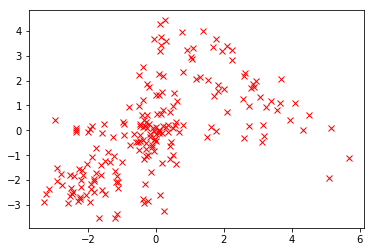

In [19]:
>>> import numpy as np
>>> y0 = np.random.multivariate_normal([0, 0], [[2, 0], [0, 0.1]], size=50)
>>> y1 = np.random.multivariate_normal([0, 0], [[0.1, 0], [0, 2]], size=50)
>>> y2 = np.random.multivariate_normal([2, 2], [[2, -1.5], [-1.5, 2]], size=50)
>>> y3 = np.random.multivariate_normal([-2, -2], [[0.5, 0], [0, 0.5]], size=50)
>>> y = np.vstack([y0, y1, y2, y3])
>>> import bayespy.plot as bpplt
>>> bpplt.pyplot.plot(y[:,0], y[:,1], 'rx')

In [20]:
>>> N = 200
>>> D = 2
>>> K = 10
>>> from bayespy.nodes import Dirichlet, Categorical
>>> alpha = Dirichlet(1e-5*np.ones(K),
...                   name='alpha')
>>> Z = Categorical(alpha,
...                 plates=(N,),
...                 name='z')
>>> from bayespy.nodes import Gaussian, Wishart
>>> mu = Gaussian(np.zeros(D), 1e-5*np.identity(D),
...               plates=(K,),
...               name='mu')
>>> Lambda = Wishart(D, 1e-5*np.identity(D),
...                  plates=(K,),
...                  name='Lambda')
>>> from bayespy.nodes import Mixture
>>> Y = Mixture(Z, Gaussian, mu, Lambda,
...             name='Y')
>>> Z.initialize_from_random()
>>> from bayespy.inference import VB
>>> Q = VB(Y, mu, Lambda, Z, alpha)
>>> Y.observe(y)
>>> Q.update(repeat=1000)

Iteration 1: loglike=-1.411109e+03 (0.006 seconds)
Iteration 2: loglike=-1.280158e+03 (0.009 seconds)
Iteration 3: loglike=-1.272963e+03 (0.006 seconds)
Iteration 4: loglike=-1.267576e+03 (0.006 seconds)
Iteration 5: loglike=-1.261818e+03 (0.006 seconds)
Iteration 6: loglike=-1.254271e+03 (0.006 seconds)
Iteration 7: loglike=-1.246147e+03 (0.006 seconds)
Iteration 8: loglike=-1.240166e+03 (0.006 seconds)
Iteration 9: loglike=-1.236238e+03 (0.006 seconds)
Iteration 10: loglike=-1.233106e+03 (0.006 seconds)
Iteration 11: loglike=-1.229993e+03 (0.007 seconds)
Iteration 12: loglike=-1.226419e+03 (0.006 seconds)
Iteration 13: loglike=-1.221879e+03 (0.006 seconds)
Iteration 14: loglike=-1.215554e+03 (0.006 seconds)
Iteration 15: loglike=-1.205453e+03 (0.006 seconds)
Iteration 16: loglike=-1.178147e+03 (0.006 seconds)
Iteration 17: loglike=-1.134564e+03 (0.005 seconds)
Iteration 18: loglike=-1.064071e+03 (0.006 seconds)
Iteration 19: loglike=-1.058233e+03 (0.006 seconds)
Iteration 20: loglike

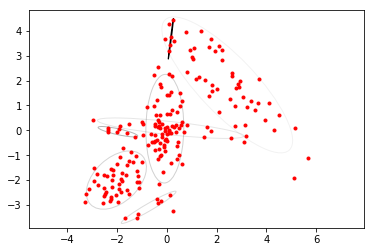

In [21]:
>>> bpplt.gaussian_mixture_2d(Y, alpha=alpha, scale=2)

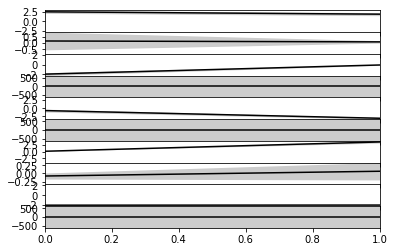

In [22]:
import bayespy
P = bayespy.plot.GaussianTimeseriesPlotter()
P(mu)

In [23]:
np.random.seed(1)
At = np.random.normal(0, 1, size=(10,))
Bt = np.random.binomial(100,0.1,size=(10,)) + np.random.normal(0, 0.001, size=(10,))-1

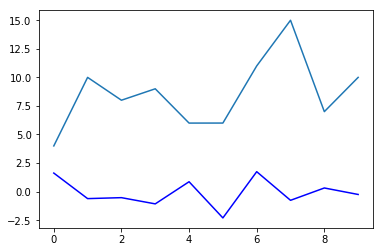

In [24]:
plt.plot(At,'b')
plt.plot(Bt)
plt.show()

In [25]:
from pgmpy.models import NaiveBayes
G = NaiveBayes()
G.add_nodes_from('a')
G.add_nodes_from('b')
G.add_edge('a', 'b')

In [26]:
values = pd.DataFrame(np.random.randint(low=0, high=2, size=(1000, 2)),columns=['a','b'])
G.fit(values, 'a')

In [27]:
G.get_cpds()
ind = G.local_independencies('a')
from pgmpy.models.BayesianModel import BayesianModel

/Users/songzeli/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


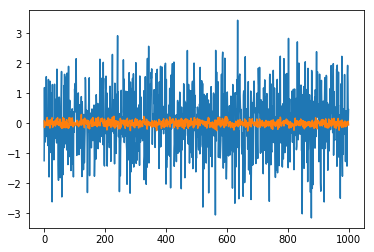

In [28]:
ts_len = 1000
At = np.random.normal(0, 1, size=(ts_len,))
# Bt = np.random.binomial(100,0.1,size=(100,)) + np.random.normal(0, 0.001, size=(100,))-10
Bt = 0.1*np.random.normal(10, 1e-10, size=(ts_len,))+(1-0.1)*np.random.normal(0, 0.1, size=(ts_len,))-1

# from pypr.clustering import *
from numpy import *
from scipy.stats import norm
# centroids=[array([10,10])]
# ccov=[array([[1,0],[0,1]])]
# samples = 10
# gmm.sample_gaussian_mixture(centroids, ccov, samples=samples)


A_STS = refined_AAFT_surrogates(At,100)
B_STS = refined_AAFT_surrogates(Bt,100)
plt.plot(A_STS)
plt.plot(B_STS)


#P(B)
from sklearn.mixture import GaussianMixture
from sklearn.mixture import GMM


# x = x = np.linspace(-10,10,200)
A_pdf = norm.pdf(A_STS,0,1)


from statsmodels.distributions.mixture_rvs import mixture_rvs
import statsmodels.api as sm
kde = sm.nonparametric.KDEUnivariate(B_STS)
kde.fit()

B_pdf = kde.evaluate(B_STS)/10



# gmm = GaussianMixture(n_components=2)
# gmm.fit(B_STS.reshape(-1,1))
# print(gmm.means_)
# print(gmm.covariances_)
# lin_param = (-8, 8, 100)
# x = np.linspace(*lin_param)
# y = np.linspace(*lin_param)

# xx, yy = np.meshgrid(x, y)
# pos = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis = 1)
# z = gmm.score_samples(pos) # Note that this method returns log-likehood
# # z = np.exp(gmm.score_samples(pos)) # e^x to get likehood values
# z = z.reshape(xx.shape)

# plt.contourf(x, y, z, 50, cmap="viridis")
# plt.show()

In [29]:
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_classif
# IM = mutual_info_score(A_STS[300:400],B_STS[300:400])
# MI = mutual_info_score(At,Bt)

In [30]:
p = 0.1
bins = 8
JPD_ts = A_pdf*B_pdf
from mutual_info import mutual_information_2d
start = np.random.randint(ts_len-20, size=20)
sample_A_STS = [A_STS[i:i+20] for i in start]
sample_B_STS = [B_STS[i:i+20] for i in start]
sample_At = [At[i:i+20] for i in start]
sample_Bt = [Bt[i:i+20] for i in start]
MI = [mutual_information_2d(sample_A_STS[i],sample_B_STS[i]) for i in range(20)]
MI_t = [mutual_information_2d(sample_At[i],sample_Bt[i]) for i in range(20)]
MI_p = mutual_information_2d(A_pdf,B_pdf,JPD=JPD_ts,input_JPD=True)
IM = max(MI)
H,x_edge,y_edge=np.histogram2d(At,Bt,bins=[bins,bins])

In [31]:
JPD = H/sum(H)
JPD.shape

(8, 8)

In [32]:
MI_p = MI_p/(ts_len/20)
r = np.abs(MI_p-IM)/IM
print(r)

2.3889964226690767


In [35]:
while r>= p:
    x1 = np.random.uniform(x_edge[0],x_edge[-1])
    x2 = np.random.uniform(x_edge[0],x_edge[-1])
    y1 = np.random.uniform(y_edge[0],y_edge[-1])
    y2 = np.random.uniform(y_edge[0],y_edge[-1])
    x1_indx = [i for i in range(len(x_edge)-1) if x1>x_edge[i] and x1<x_edge[i+1]][0]
    y1_indx = [i for i in range(len(y_edge)-1) if y1>y_edge[i] and y1<y_edge[i+1]][0]
    x2_indx = [i for i in range(len(x_edge)-1) if x2>x_edge[i] and x2<x_edge[i+1]][0]
    y2_indx = [i for i in range(len(y_edge)-1) if y2>y_edge[i] and y2<y_edge[i+1]][0]
    delta = JPD*np.random.uniform(0, 1)
    JPD_up = JPD
    JPD_up[x1_indx,y1_indx] = JPD[x1_indx,y1_indx]+delta[x1_indx,y1_indx]
    JPD_up[x1_indx,y2_indx] = JPD[x1_indx,y2_indx]-delta[x1_indx,y2_indx]
    JPD_up[x2_indx,y1_indx] = JPD[x2_indx,y1_indx]-delta[x2_indx,y1_indx]
    JPD_up[x2_indx,y2_indx] = JPD[x2_indx,y2_indx]+delta[x2_indx,y2_indx]  
    JPD_up = JPD_up/sum(JPD_up)
    JPD_up_ts = JPD_ts
    for i in range(len(A_pdf)):
        for j in range(bins):
            for k in range(bins):
                if A_pdf[i]>x_edge[j] and B_pdf[i]>y_edge[k]: 
                    JPD_up_ts[i] = JPD_up[j][k]

#     print(JPD_up.shape)
    MI_up = mutual_information_2d(A_pdf,B_pdf,JPD=JPD_up_ts,input_JPD=True)
    print(MI_up)
    r_up = np.abs(MI_up-IM)/IM
    print(r_up)
    if r_up < r:
        r = np.abs(MI_up-IM)/IM
        JPD = JPD_up

    print(r)
    

(8, 8)
-23.727077180819435
9.803057181270056
2.3889964226690767
(8, 8)
-23.842607921709543
9.845920603110832
2.3889964226690767
(8, 8)
-23.806439131561618
9.832501507053482
2.3889964226690767
(8, 8)
-23.805849124484553
9.832282606680833
2.3889964226690767
(8, 8)
-23.805849124484553
9.832282606680833
2.3889964226690767
(8, 8)
-21.836155153576932
9.101500280507112
2.3889964226690767
(8, 8)
-25.157514770924102
10.333768309487267
2.3889964226690767
(8, 8)
-25.3522461532312
10.406016209233758
2.3889964226690767
(8, 8)
-25.3522461532312
10.406016209233758
2.3889964226690767
(8, 8)
-24.77165144917639
10.190607950560048
2.3889964226690767
(8, 8)
-24.369840278726613
10.041530730361945
2.3889964226690767
(8, 8)
-24.369840278726613
10.041530730361945
2.3889964226690767
(8, 8)
-24.38002105026812
10.045307930281949
2.3889964226690767
(8, 8)
-25.33420029429704
10.399320958618949
2.3889964226690767
(8, 8)
-26.117303856198873
10.689862662586213
2.3889964226690767
(8, 8)
-22.89466816420375
9.4942225062

(8, 8)
-5.857127374720243
3.173071162735762
2.3889964226690767
(8, 8)
-5.857127374720243
3.173071162735762
2.3889964226690767
(8, 8)
-5.946165628583543
3.2061055240313325
2.3889964226690767
(8, 8)
-5.946165628583543
3.2061055240313325
2.3889964226690767
(8, 8)
-5.946165628583543
3.2061055240313325
2.3889964226690767
(8, 8)
-5.935578378041203
3.202177515064767
2.3889964226690767
(8, 8)
-5.850794321652778
3.1707215168919
2.3889964226690767
(8, 8)
-5.8568364644602156
3.1729632312095095
2.3889964226690767
(8, 8)
-5.85679797400465
3.1729489507450976
2.3889964226690767
(8, 8)
-5.85679797400465
3.1729489507450976
2.3889964226690767
(8, 8)
-5.85679797400465
3.1729489507450976
2.3889964226690767
(8, 8)
-5.859602772087584
3.1739895676621255
2.3889964226690767
(8, 8)
-5.858371836748368
3.1735328744885423
2.3889964226690767
(8, 8)
-5.85529474652062
3.1723912336104703
2.3889964226690767
(8, 8)
-5.855263537062257
3.1723796544916234
2.3889964226690767
(8, 8)
-5.857652931081525
3.173266151046589
2.388

In [38]:
JPD_up

array([[0.00000000e+00, 2.34638556e-03, 3.38831089e-08, 6.22867582e-04,
        1.36874080e-06, 3.52141460e-03, 2.33665420e-06, 0.00000000e+00],
       [0.00000000e+00, 2.00491912e-04, 1.29762492e-03, 5.91160866e-06,
        3.61085110e-05, 2.08189925e-04, 3.73603125e-05, 0.00000000e+00],
       [3.30100070e-06, 1.46556512e-02, 6.88623820e-03, 6.44876856e-05,
        9.73682601e-03, 3.96391897e-02, 8.89918152e-07, 0.00000000e+00],
       [6.12154103e-05, 4.04262170e-07, 7.06148937e-03, 6.48951023e-04,
        3.09215191e-02, 1.45675217e-08, 1.95849747e-02, 0.00000000e+00],
       [3.04455538e-07, 2.21932031e-04, 8.00392639e-03, 2.13417855e-03,
        8.31024642e-01, 1.05044084e-04, 2.06262758e-06, 2.52183485e-06],
       [2.41303055e-04, 1.25819923e-05, 4.41513732e-04, 3.03343606e-05,
        4.46539181e-03, 2.65438568e-04, 1.81640986e-04, 9.21800618e-05],
       [8.30734772e-08, 1.75703207e-05, 1.20065763e-02, 2.31216510e-03,
        6.25048264e-06, 6.84137792e-04, 3.67144726e-05, 0.